# Анализ по средней ЗП

Здесь мои расчёты для [статьи](https://medium.com/@bjolko/%D0%BF%D1%80%D0%BE%D0%B4%D0%BE%D0%BB%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5-%D0%BF%D1%80%D0%B5%D0%B4%D1%8B%D0%B4%D1%83%D1%89%D0%B5%D0%B9-%D1%81%D1%82%D0%B0%D1%82%D1%8C%D0%B8-%D1%81%D0%B5%D0%B3%D0%BE%D0%B4%D0%BD%D1%8F-%D0%BF%D0%BE%D1%81%D0%BC%D0%BE%D1%82%D1%80%D0%B8%D0%BC-%D0%BD%D0%B0-%D1%80%D0%B0%D0%B7%D0%BB%D0%B8%D1%87%D0%B8%D1%8F-%D0%B2-%D0%B7%D0%B0%D1%80%D0%BF%D0%BB%D0%B0%D1%82%D0%B0%D1%85-eba9ec985ce5).

**Содержание**
1. Импорт данных из .docx формата
2. Предобработка и графики

## Настройки и подгрузка библиотек

In [1]:
options(warn = -1, repr.plot.height = 6, repr.plot.width = 9, scipen = 999)

In [16]:
library(dplyr)
library(stringr)
library(docxtractr)
library(ggplot2)
library(openxlsx)
library(qdap)
library(magick)
library(waffle)
library(extrafont)

In [3]:
k_formatter <- function(x){
    
    ### Преобразует числа в формат K
    
    paste0(format(round(x/1000), big.mark = ' '), 'K')
} 

salary_to_num <- function(x) {
    
  ### Преобразует текстовые данные в числовые
    
  as.numeric(str_replace_all(x, '[[:space:]]', ''))
}

## Импорт данных

In [4]:
# Данные об оплате труда
salary_location <- './data/salary.docx'
salary_doc <- docxtractr::read_docx(salary_location)

# Данные о занятости
employment_location <- './data/employment.docx'
employment_doc <- docxtractr::read_docx(employment_location)

In [5]:
# Тема для визуализаций

sex_colors_dark <- c('#C84E9E', '#4881A9')
sex_colors_light <- c('#DB75B7', '#6FA2C6')

viz_theme <- 
  theme(legend.position = 'none',
        axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank(),
        panel.background = element_rect(fill = '#FFF2D9'),
        #plot.background = element_rect(fill = '#FFF4B3'),
        panel.grid.major.y = element_line(colour = '#FFD788', size = .5),
        panel.grid.major.x = element_blank(),
        panel.grid.minor = element_blank(),
        plot.title = element_text(face = 'bold'),
        plot.subtitle = element_text(face = 'italic'),
        text = element_text(size = 11))

## Анализ

In [6]:
# Зарплаты по отраслям и полу
salary_field <- 
  docx_extract_tbl(salary_doc, 70) %>% 
  setNames(., c('field_kz', 'men', 'women', 'field_ru')) %>% 
  mutate_at(vars(contains('men')), ~salary_to_num(.)) %>% 
  select(-field_kz) %>% 
  select(field_ru, everything()) %>% 
  filter(!is.na(men),
         field_ru %in% c('По всем видам деятельности',
                         'Промышленность',
                         'Строительство',
                         'Информация и связь',
                         'Финансовая и страховая деятельность',
                         'Образование',
                         'Здравоохранение и социальные услуги')) %>% 
  mutate(field_ru = recode(field_ru, 
                           'Информация и связь' = 'IT',
                           'Финансовая и страховая деятельность' = 'Финансы',
                           'Здравоохранение и социальные услуги' = 'Здравоохранение')) %>% 
  tidyr::gather(sex, salary, -field_ru) %>% 
  mutate(sex = recode(sex, 'men' = 'Мужчины', 'women' = 'Женщины'),
         sex = reorder(sex, salary),
         salary_label = scales::number(round(salary/1000, 1) * 1000));salary_field

field_ru,sex,salary,salary_label
<chr>,<fct>,<dbl>,<chr>
По всем видам деятельности,Мужчины,161817,161 800
Промышленность,Мужчины,207492,207 500
Строительство,Мужчины,144780,144 800
IT,Мужчины,214470,214 500
Финансы,Мужчины,358143,358 100
Образование,Мужчины,96986,97 000
Здравоохранение,Мужчины,114551,114 600
По всем видам деятельности,Женщины,119177,119 200
Промышленность,Женщины,147687,147 700


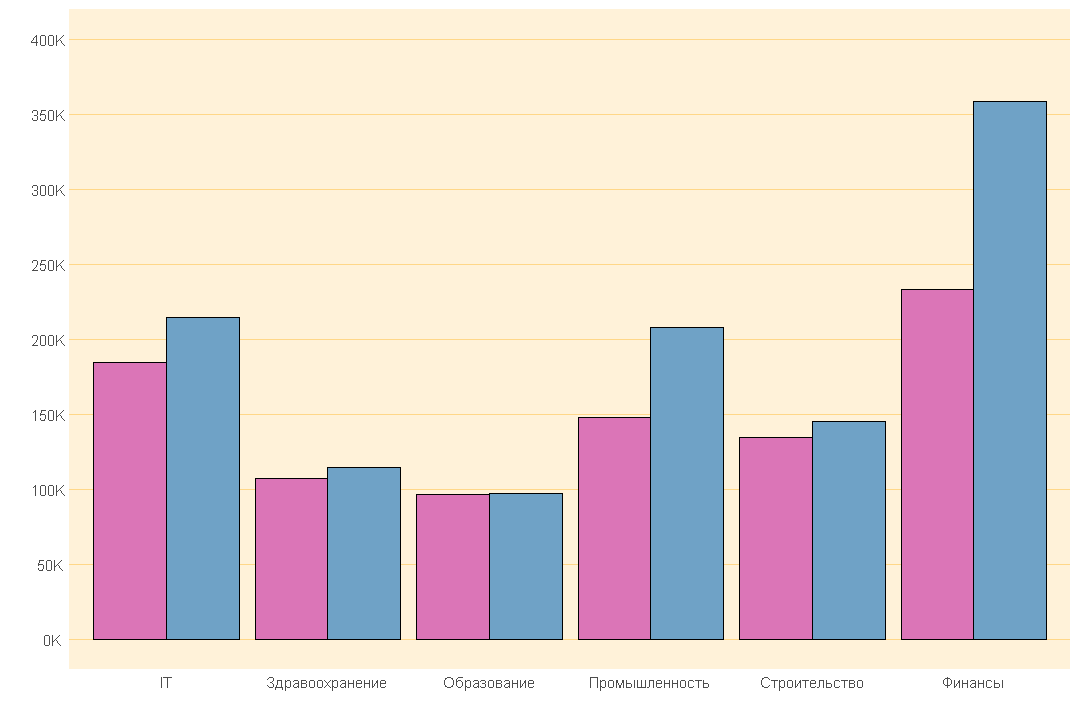

In [7]:
# Зарплата по отраслям
salary_field %>% 
  filter(field_ru != 'По всем видам деятельности') %>% 
  ggplot(aes(x = field_ru, y = salary, fill = sex)) +
  geom_bar(stat = 'identity', position = 'dodge', color = 'black') +
  scale_y_continuous(limits = c(0, 400000), breaks = seq(0, 400000, 50000), labels = k_formatter) +
  scale_fill_manual(values = sex_colors_light) +
  labs(x = '', y = '', fill = '') +
  viz_theme +
  theme(axis.text.x = element_text(),
        axis.text.y = element_text())

In [8]:
# Динамика ЗП

salary_extract <- function(doc_num) {
  docx_extract_tbl(salary_doc, doc_num) %>% 
    setNames(c('field_kz', c(2013:2017), 'field_ru')) %>% 
    slice(2)
}

salary_dynamics <- 
  rbind(salary_extract(72), salary_extract(73)) %>% 
  select(-contains('field')) %>% 
  mutate(sex = c('male', 'female')) %>% 
  tidyr::gather(year, salary, - sex) %>% 
  mutate(salary = salary_to_num(salary))

woman_last_salary <- 
  salary_dynamics %>% 
  filter(sex == 'female') %>% 
  pull(salary) %>% 
  max()

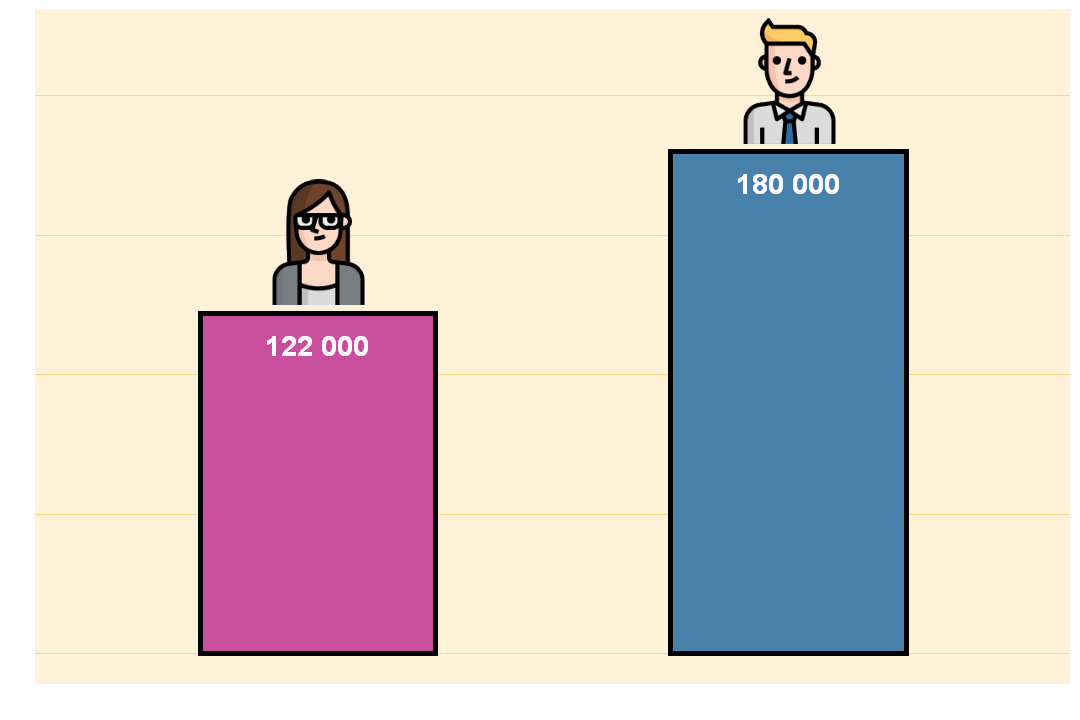

In [9]:
# Средняя ЗП мужчин и женщин в 2017 году
# иконки от monkik
woman_banker <- 
  magick::image_read_svg('./icons/woman.svg', width = 150) %>% 
  grid::rasterGrob(., interpolate = T)

man_banker <- 
  magick::image_read_svg('./icons/man.svg', width = 150) %>% 
  grid::rasterGrob(., interpolate = T)

salary_dynamics %>% 
  filter(year == 2017) %>% 
  mutate(salary = round(salary / 1000) * 1000,
         salary_label = scales::number(salary)) %>% 
  ggplot(aes(x = sex, y = salary, fill = sex)) +
  geom_bar(stat = 'identity', position = 'dodge', width = .5, color = 'black', size = 1.5) +
  geom_text(aes(label = salary_label), vjust = 2, size = 6, fontface = 'bold', col = '#FFFAFF') +
  scale_y_continuous(label = k_formatter, limits = c(0, 220000)) + 
  scale_fill_manual(values = sex_colors_dark) + 
  labs(x = '', y = '') +
  annotation_custom(woman_banker, ymin = 125000, ymax = 170000, xmin = .8, xmax = 1.2) +
  annotation_custom(man_banker, ymin = 182782, ymax = 227782, xmin = 1.8, xmax = 2.2) +
  viz_theme

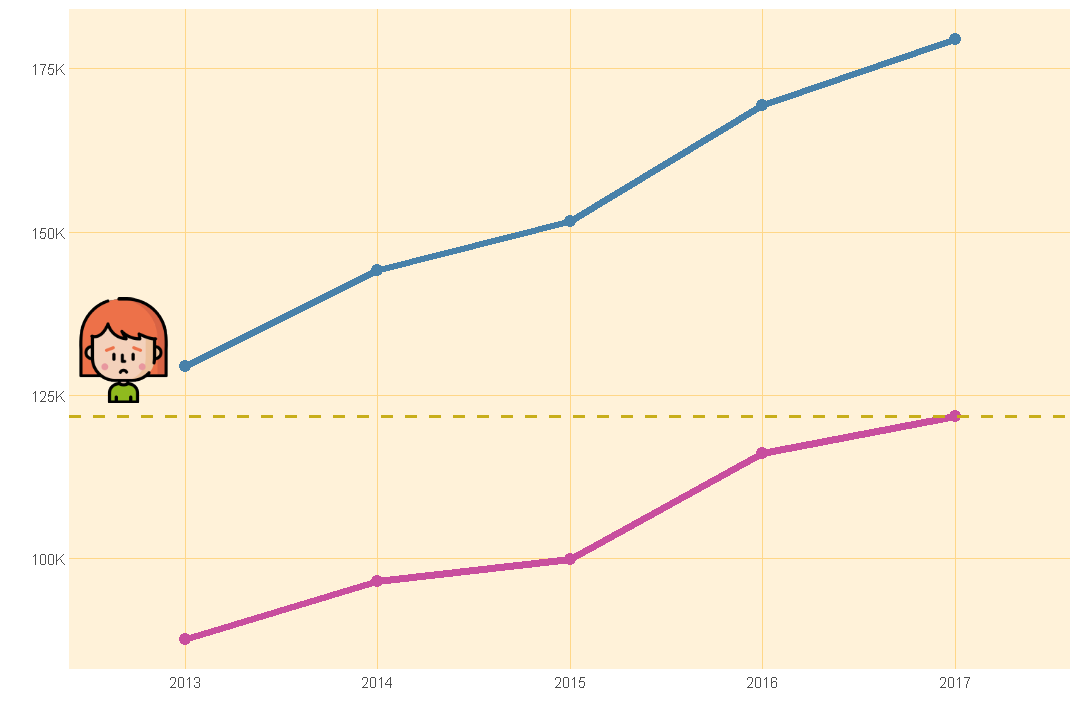

In [10]:
# Динамика ЗП 2013-2017

# иконка от freepik 
record <- 
  image_read_svg('./icons/record_sans.svg', width = 150) %>% 
  grid::rasterGrob(., interpolate = T)

salary_dynamics %>% 
  mutate(sex = recode(sex, 'male' = 'Мужчины', 'female' = 'Женщины')) %>% 
  ggplot(aes(x = year, y = salary, color = sex, group = sex)) +
  geom_point(size = 3) +
  geom_line(size = 2) +
  geom_hline(yintercept = woman_last_salary, color = '#C8AE1A', linetype = 'dashed', size = 1) +
  annotation_custom(record, ymin = woman_last_salary + 2000, ymax = 140000, xmin = 0.35, xmax = 1) +
  scale_y_continuous(#limits = c(50000, 200000), 
                     breaks = seq(50000, 200000, 25000), 
                     labels = k_formatter) +
  scale_color_manual(values = sex_colors_dark) +
  labs(x = '', y = '', color = '') +
  viz_theme +
  theme(#legend.position = 'bottom',
        axis.text.x = element_text(),
        axis.text.y = element_text(),
        panel.grid.major.x = element_line(colour = '#FFD788', size = .5))

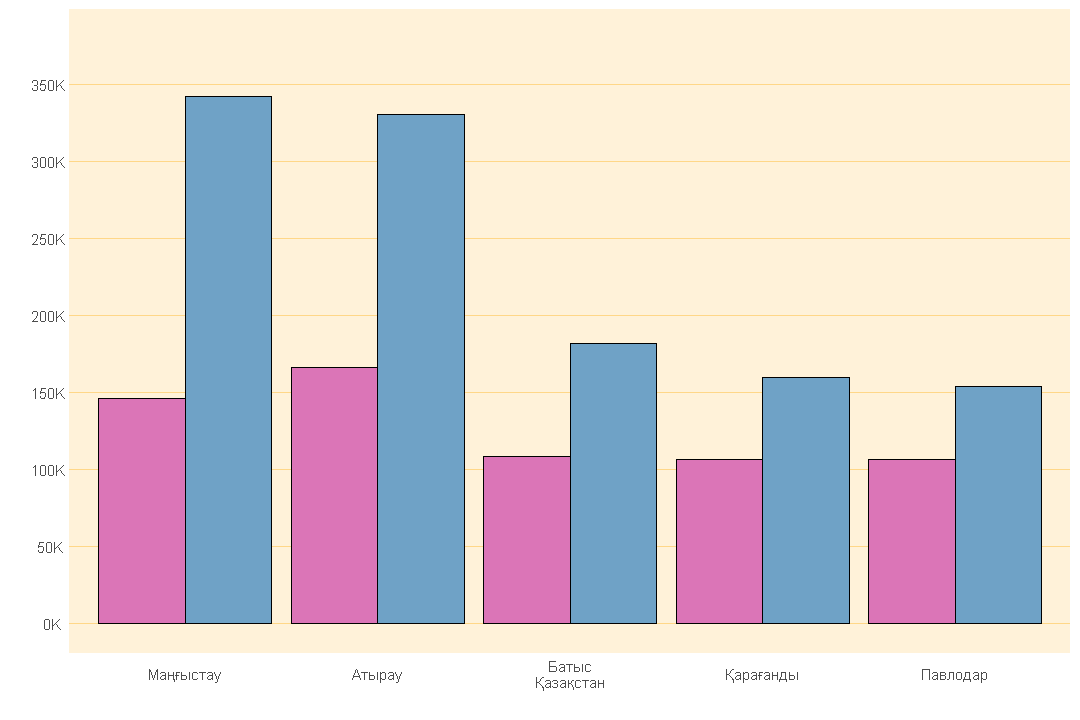

In [11]:
# ЗП по регионам с наибольшим разрывом

salary_region <- 
  docx_extract_tbl(salary_doc, 165) %>% 
  setNames(c('region', paste0('Мужчины_', 2013:2017), paste0('Женщины_', 2013:2017))) %>% 
  filter(region != '') %>% 
  tidyr::gather(key, salary, -region) %>% 
  tidyr::separate(key, c('sex', 'year')) %>% 
  mutate_at(vars(sex, year), ~str_trim(.)) %>% 
  mutate(salary = salary_to_num(salary)) %>% 
  filter(year == '2017')

salary_region %>% 
  filter(!str_detect(region, 'Республика')) %>% 
  mutate(region = ifelse(str_detect(region, '[[:space:]]'), str_replace(region, ' ', '\n'), region)) %>% 
  group_by(region) %>%
  mutate(gap = (max(salary) - min(salary)) / max(salary)) %>% 
  ungroup %>% 
  arrange(-gap) %>% 
  slice(1:10) %>% 
  mutate(region = reorder(region, -gap)) %>% 
  ggplot(aes(x = region, y = salary, fill = sex)) +
  geom_bar(stat = 'identity', position = 'dodge', color = 'black', size = .5) +
  scale_y_continuous(limits = c(0, 380000), breaks = seq(0, 380000, 50000), labels = k_formatter) +
  scale_fill_manual(values = sex_colors_light) +
  labs(x = '', y = '', fill = '') +
  viz_theme +
  theme(axis.text.x = element_text(),
        axis.text.y = element_text())

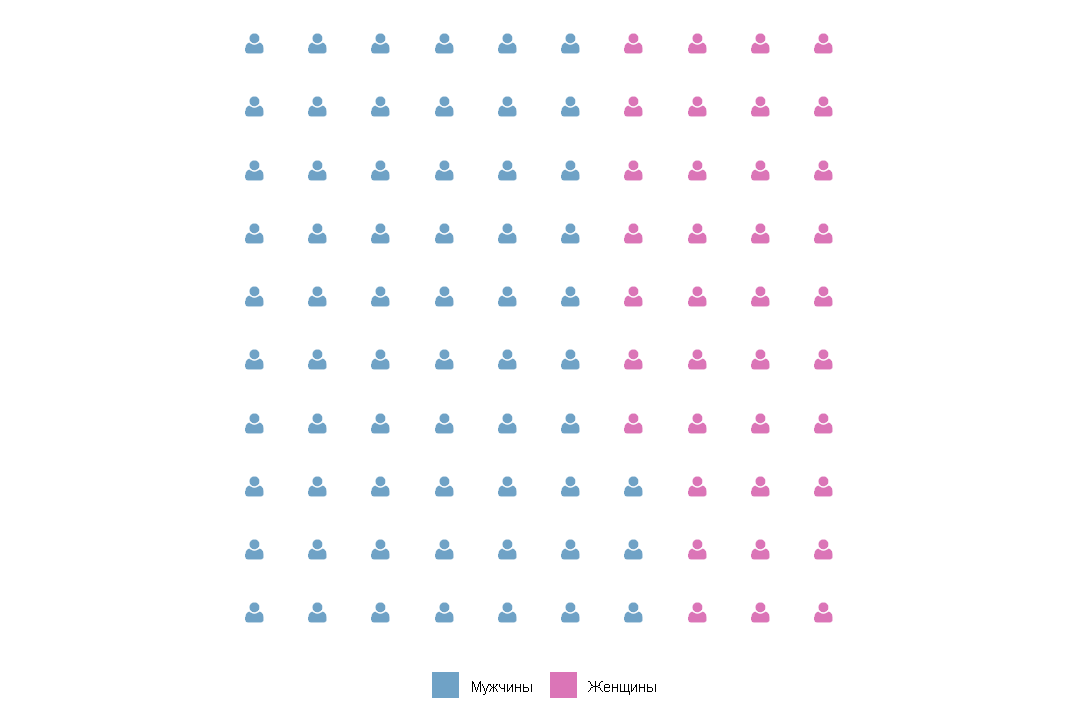

In [12]:
# Занятость по должностям
employment_position <- 
  docx_extract_tbl(employment_doc, 47, header = F) %>% 
  na_if('') %>% 
  select(6:7) %>% 
  slice(15:40) %>% 
  filter(!is.na(V6)) %>% 
  setNames(c('n', 'type')) %>% 
  mutate(sex = ifelse(row_number() <= 11, 'Мужчины', 'Женщины'),
         n = str_remove_all(str_replace_all(n, ',', '.'), '[[:space:]]'),
         n = as.numeric(n)) %>% 
  group_by(sex) %>% 
  filter(!str_detect(type, 'всего')) %>% 
  mutate(sum_n = sum(n),
         share = n / sum_n,
         type = str_trim(clean(type))) %>% 
  ungroup

# Попытка построить waffle chart соотношения мужчин / женщин среди руководителей
employment_position %>% 
  filter(str_detect(type, 'Руководители')) %>% 
  mutate(share = round(n/sum(n), 2) * 100) %>% 
  select(names = sex, vals = share) %>% 
  waffle(keep = F,
         rows = 10,
         glyph_size = 5,
         colors = rev(sex_colors_light),
         legend_pos = 'bottom',
         glyph_font = 'FontAwesome',
         glyph_font_family = 'FontAwesome',
         use_glyph = 'user')

In [13]:
# ЗП руководителей в 2017
salary_position <-
  docx_extract_tbl(salary_doc, 79) %>%
  setNames(., c('position_kz', 'all', 'men', 'women', 'position_ru')) %>%
  mutate_at(vars(contains('men')), ~salary_to_num(.)) %>%
  filter(!is.na(men)) %>%
  select(position_ru, men, women) %>%
  tidyr::gather(sex, salary, -position_ru) %>% 
  filter(str_detect(position_ru, 'руководител'))

managers <- 
  employment_position %>% 
  filter(str_detect(type, 'Руководители')) %>% 
  mutate(share = scales::percent(n/sum(n))) %>% 
  select(sex = sex, share) %>% 
  inner_join(salary_position %>% 
               select(-position_ru) %>% 
               mutate(sex = recode(sex, 'men' = 'Мужчины', 'women' = 'Женщины'),
                      salary = scales::number(salary)), by = 'sex') %>% 
  setNames(c('Пол', 'Доля', 'Зарплата')); managers

Пол,Доля,Зарплата
<chr>,<chr>,<chr>
Мужчины,63.3%,349 122
Женщины,36.7%,231 356


In [14]:
# Доля уволившихся, которые указали причину Ведение домашнего хозяйства
docx_extract_tbl(employment_doc, 59, header = F) %>% 
  na_if('') %>% 
  na_if('-') %>% 
  select(6:7) %>% 
  setNames(c('n', 'type')) %>% 
  filter(!is.na(n), !str_detect(type, 'всего')) %>% 
  slice(13:36) %>% 
  mutate(sex = ifelse(row_number() < 13, 'Мужчины', 'Женщины'),
         n = str_remove_all(str_replace_all(n, ',', '.'), '[[:space:]]'),
         n = as.numeric(n)) %>% 
  group_by(sex) %>% 
  mutate(sum_n = sum(n)) %>% 
  ungroup %>% 
  mutate(share = n/sum_n) %>% 
  filter(type == 'ведения домашнего хозяйства') %>% 
  select(sex, share) %>% 
  mutate(share = scales::percent(share))

sex,share
<chr>,<chr>
Мужчины,2.6%
Женщины,14.2%


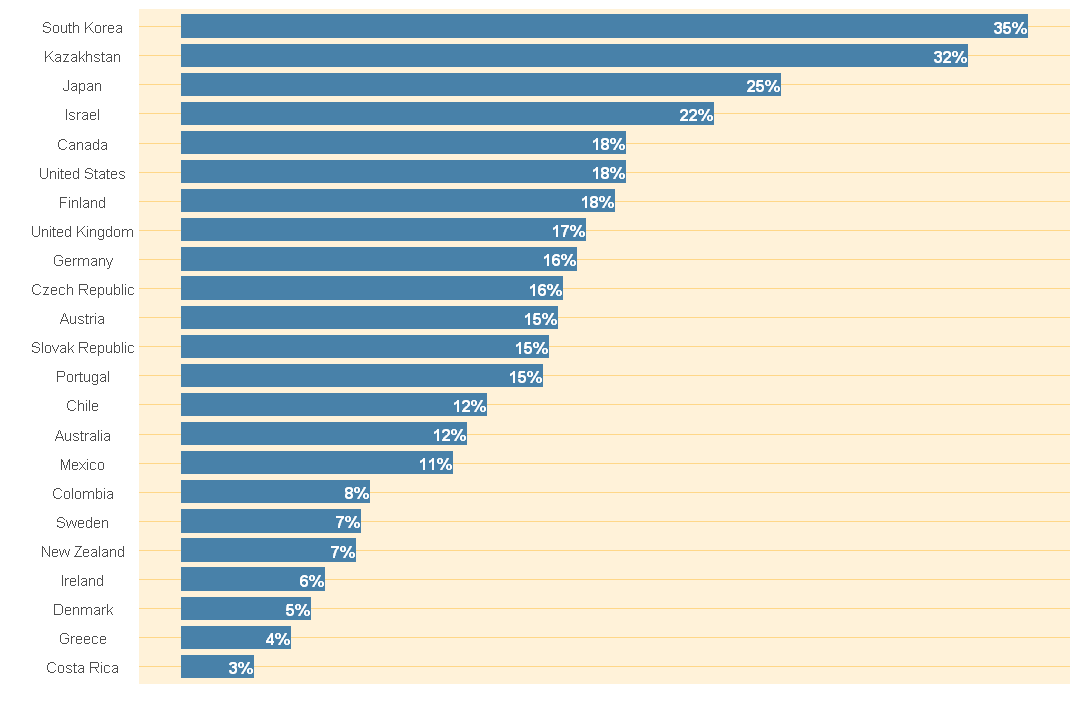

In [15]:
# Сравнение Казахстана с другими странами по данным OECD в 2017 году

kz_salary_gap <- 
  salary_dynamics %>% 
  filter(year == 2017)%>% 
  mutate(kz_gap = (max(salary) - min(salary))*100/max(salary)) %>% 
  pull(kz_gap) %>% unique

codes_dict <- read.xlsx('./data/location_codes.xlsx')

oecd <- 
  data.table::fread('./data/OECD_pay_gap.csv') %>% 
  select_all(tolower) %>% 
  filter(time == 2017, subject == 'EMPLOYEE', indicator == 'WAGEGAP', location != 'OECD') %>% 
  select(location, value) %>% 
  rbind(c('USSR-KAZ', kz_salary_gap)) %>% 
  mutate_at(vars(value), ~as.numeric(.)) %>% 
  left_join(codes_dict, by = 'location') %>% 
  select(country, value)

oecd %>% 
  arrange(-value) %>% 
  mutate(country = reorder(country, value)) %>% 
  ggplot(aes(x = country, y = value)) +
  geom_bar(stat = 'identity', fill = '#4881A9', width = .8) +
  geom_text(aes(label = paste0(round(value), '%')), hjust = 1., size = 3.5, fontface = 'bold', color = 'white') +
  coord_flip() +
  labs(x = '', y = '') +
  viz_theme +
  theme(axis.text.y = element_text())
